Import the necessary packages and create the connection

In [44]:
from pymongo import MongoClient
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth, Circle, Marker, Icon, Map
from folium.plugins import HeatMap, MarkerCluster
import requests
from pymongo import GEOSPHERE
import json
from dotenv import load_dotenv
from cartoframes.viz import Map, Layer, popup_element
import os
from src import myfunctions


client = MongoClient("localhost:27017")

db= client["Ironhack"]
companies=db.get_collection("companies")
target_comps=db.get_collection('target_comps')

# MongoDB query the Crunchbase dataset

From the crunchbase dataset we select companies which might be interesting to our designers and developers:
- Companies where category is 'design'
- Companies that have 'design' in the name
- Advertising agencies
- Companies that have 'design' in one of their tag-lists
- Companies in the Web space
- Start-up companies (founded after 2009)

In order to satisfy the requirement of total fundraising 1m dollars, we exclude the companies where 'total_money_raised' is below $1m.

In [2]:
df3=myfunctions.design_comps()
df3.head()

In [36]:
df3.head()

,name,category_code,number_of_employees,total_money_raised,country,city,lat,long
0,99designs,design,100,$35M,USA,San Francisco,37.795531,-122.400598
1,99designs,design,100,$35M,AUS,Collingwood,-37.802659,144.986855
2,99designs,design,100,$35M,DEU,Berlin,52.498620,13.446903
3,99designs,design,100,$35M,USA,San Francisco,37.795531,-122.400598
4,99designs,design,100,$35M,AUS,Collingwood,-37.802659,144.986855


# Find the quality countries to establish your business in

From Our World in Data get the following datasets:

- % of adults holding secondary and tertiary education
- Healthcare expenditures as % of GDP
- Corruption Perception Index
- Homicide rate (World Bank)

https://ourworldindata.org/charts?search


In [3]:
df_quality=myfunctions.get_country_data()
df_quality.head()

Create a combined index which will define the quality of the country:

- Education - higher is better
- Healthcare - higher is better
- Homicide - lower is better
- Corruption - lower is better

We give every indicator an equal weight of 25% and calculated a weighted ranking.

But before doing that we need to standardize the values by their mean and standard deviation

Text(0.5, 1.0, 'Combined quality rank')

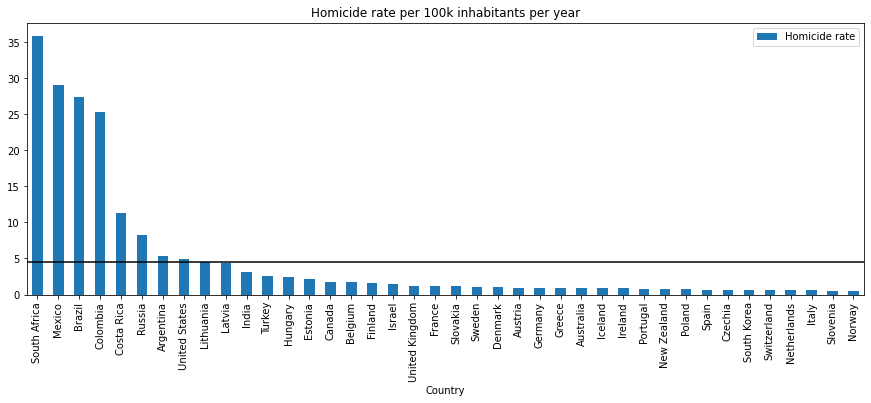

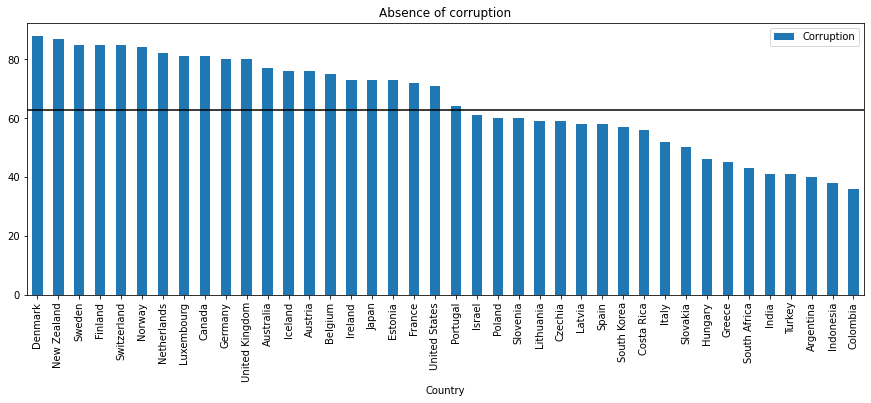

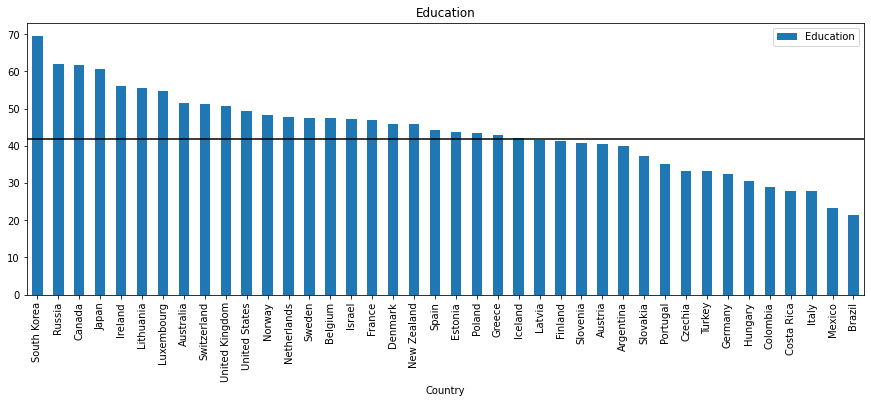

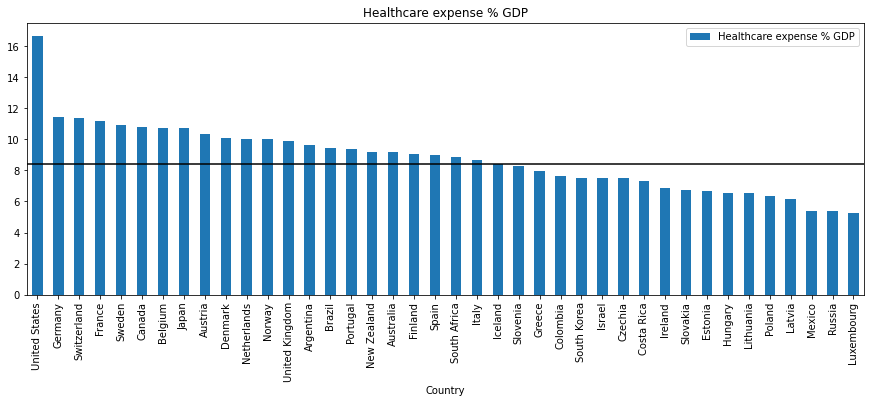

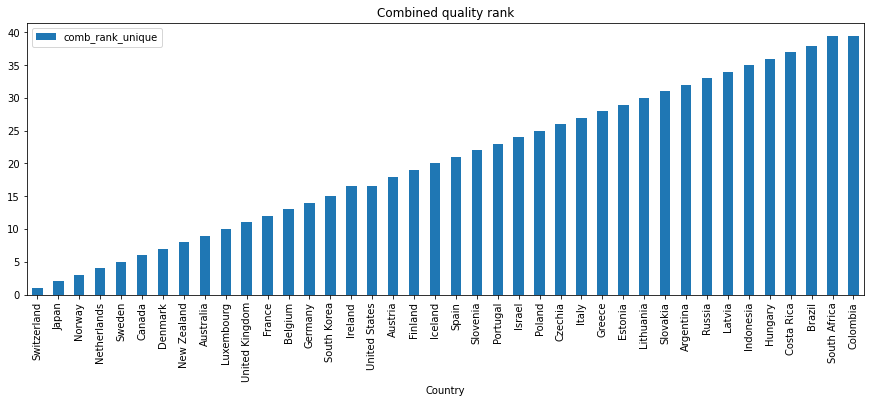

In [39]:
# Plot the country quality indices

df_quality.sort_values('Homicide rate',ascending=False, inplace=True)
ax=df_quality[:40].plot(x='Country', y='Homicide rate', kind='bar', figsize=(15,5))
ax.axhline(df_quality['Homicide rate'].mean(), color='k')
plt.title('Homicide rate per 100k inhabitants per year')

df_quality.sort_values('Corruption',ascending=False, inplace=True)
ax=df_quality[:40].plot(x='Country', y='Corruption', kind='bar', figsize=(15,5))
ax.axhline(df_quality['Corruption'].mean(), color='k')
plt.title('Absence of corruption')

df_quality.sort_values('Education',ascending=False, inplace=True)
ax=df_quality[:40].plot(x='Country', y='Education', kind='bar', figsize=(15,5))
ax.axhline(df_quality['Education'].mean(), color='k')
plt.title('Education')

df_quality.sort_values('Healthcare expense % GDP',ascending=False, inplace=True)
ax=df_quality[:40].plot(x='Country', y='Healthcare expense % GDP', kind='bar', figsize=(15,5))
ax.axhline(df_quality['Healthcare expense % GDP'].mean(), color='k')
plt.title('Healthcare expense % GDP')

df_quality.sort_values('comb_rank_unique',ascending=True, inplace=True)
ax=df_quality[:40].plot(x='Country', y='comb_rank_unique', kind='bar', figsize=(15,5))
plt.title('Combined quality rank')

In [32]:
top15_countries=df_quality['Code'][:15]
countries=list(top15_countries)

## From top countries find the suitable cities

- Filter the company database to see which of the companies are in the top 15 countries. 
- From the filtered database pick 3 top cities with the largest amount of relevant companies to us (design, advertisement, web, and tech start-ups)
- Find the mid-point between the companies in those three cities

In [7]:
top=3
df_target_comps, target_cities=myfunctions.filter_targets(df3,countries,top)

In [9]:
df_cities=myfunctions.get_city_coords(target_cities,df_target_comps)
df_cities

,City,Latitude,Longitude
0,London,51.553892,-0.145926
1,Berlin,52.503870,13.421045
2,Collingwood,-37.802659,144.986855


### Plot the maps of the three cities

In the maps below you will see the mid-point between the suitable companies in the city.

The mid-point is calcualted as a geographical mid-point where latitude = sum (latitude) / count (latitude)

In [41]:
map_1= folium.Map(location = [df_cities['Latitude'][0], df_cities['Longitude'][0]], zoom_start=13)
marker_1= folium.Marker(location = [df_cities['Latitude'][0], df_cities['Longitude'][0]], tooltip =df_cities['City'][0])
marker_1.add_to(map_1)
map_1

In [42]:
map_2= folium.Map(location = [df_cities['Latitude'][1], df_cities['Longitude'][1]], zoom_start=13)
marker_2= folium.Marker(location = [df_cities['Latitude'][1], df_cities['Longitude'][1]], tooltip =df_cities['City'][1])
marker_2.add_to(map_2)
map_2

In [43]:
map_3= folium.Map(location = [df_cities['Latitude'][2], df_cities['Longitude'][2]], zoom_start=13)
marker_3= folium.Marker(location = [df_cities['Latitude'][2], df_cities['Longitude'][2]], tooltip =df_cities['City'][2])
marker_3.add_to(map_3)
map_3

### Find the most suitable locations in the city

Search the Forsquare database for the following amenities in the area, with the respective distances:

- School (includes primary and secondary school) - 5km
- Starbucks - 2km
- Bar - 2km
- Club - 2km
- Airport - 30km
- Vegan Restaurant - 1.5km
- Basketball - 4km
- Pet grooming - 3km

In [13]:
# prepare the FourSquare API
load_dotenv()

True

In [14]:
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")
client_key=os.getenv("API_KEY")

In [25]:
#list of wishes
wishes={'school':{'distance':5000,'cat_id':12057,'sort':'DISTANCE'},
       'starbucks':{'distance':2000,'cat_id':'starbucks','sort':'DISTANCE'},
       'bar':{'distance':2000,'cat_id':13003,'sort':'DISTANCE'},
       'club':{'distance':2000,'cat_id':10032,'sort':'DISTANCE'},
       'Airport':{'distance':30000,'cat_id':19037,'sort':'RELEVANCE'},
       'vegan':{'distance':1500,'cat_id':'vegan','sort':'DISTANCE'},
       'basketball':{'distance':4000,'cat_id':18008,'sort':'DISTANCE'},
       'pet grooming':{'distance':3000,'cat_id':11134,'sort':'DISTANCE'}}

In [ ]:
lon_lat=float(df_cities['Latitude'][0])
lon_long=float(df_cities['Longitude'][0])
df_london=myfunctions.get_points_of_interest(lon_lat,lon_long,wishes)

In [27]:
myfunctions.map_markers(map_1,df_london)

In [28]:
ber_lat= float(df_cities['Latitude'][1])
ber_long= float(df_cities['Longitude'][1])
df_berlin=myfunctions.get_points_of_interest(ber_lat,ber_long,wishes)

In [29]:
myfunctions.map_markers(map_2,df_berlin)

In [30]:
mel_lat= float(df_cities['Latitude'][2])
mel_long= float(df_cities['Longitude'][2])
df_melbourne=myfunctions.get_points_of_interest(mel_lat,mel_long,wishes)

In [31]:
myfunctions.map_markers(map_3,df_melbourne)

## Compare the cost of living across these cities

I will compare the cost of living using the Numbeo comparison tool. While it has an API its usage requires a paying subscription. That is why I will rely on a simple comparison online.

### London vs Melbourne

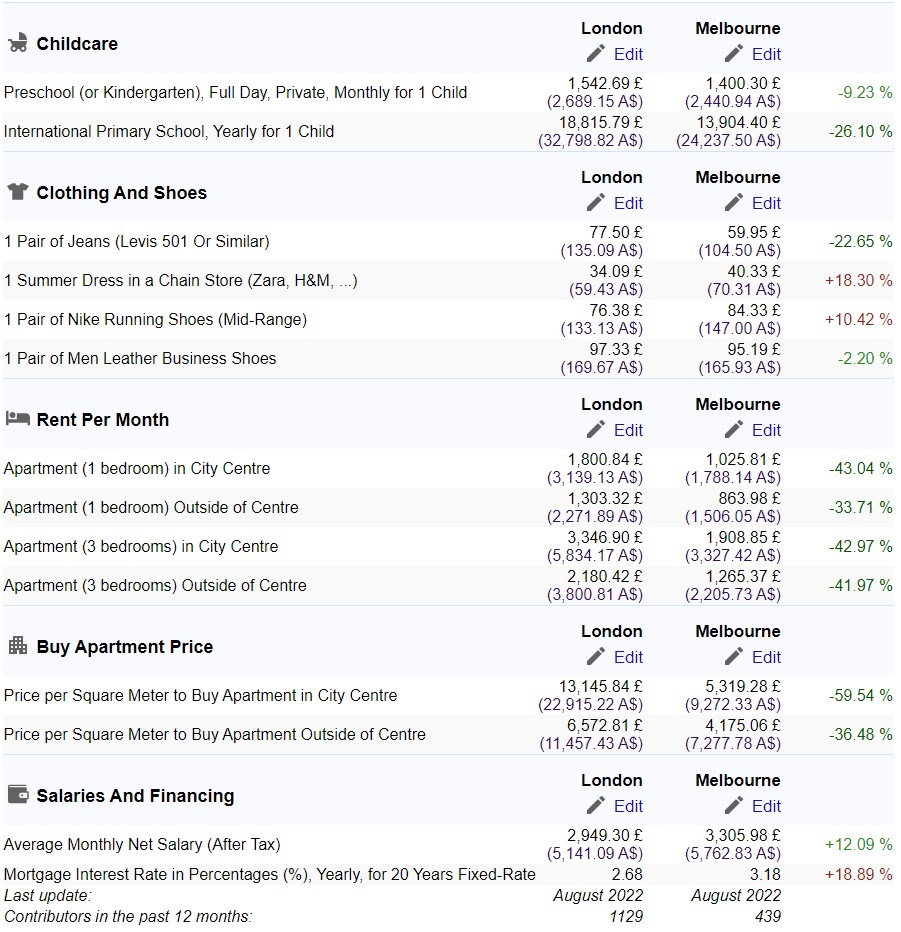

### Berlin vs Melbourne

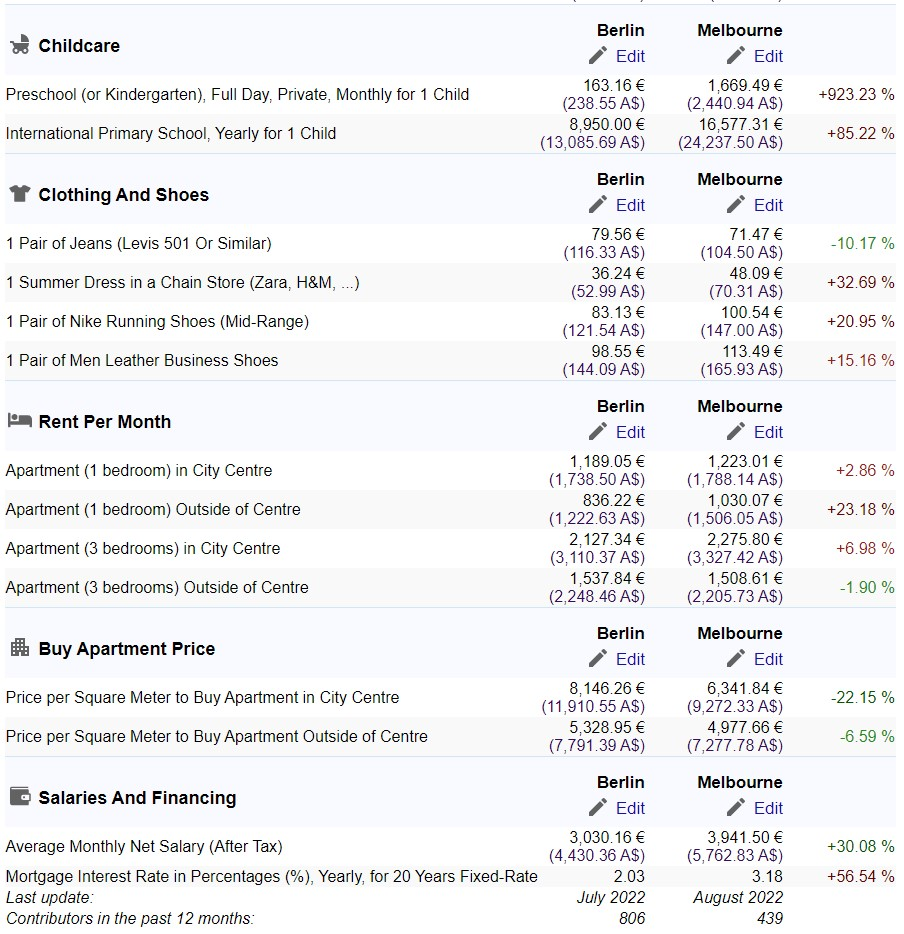

## And the winner is???

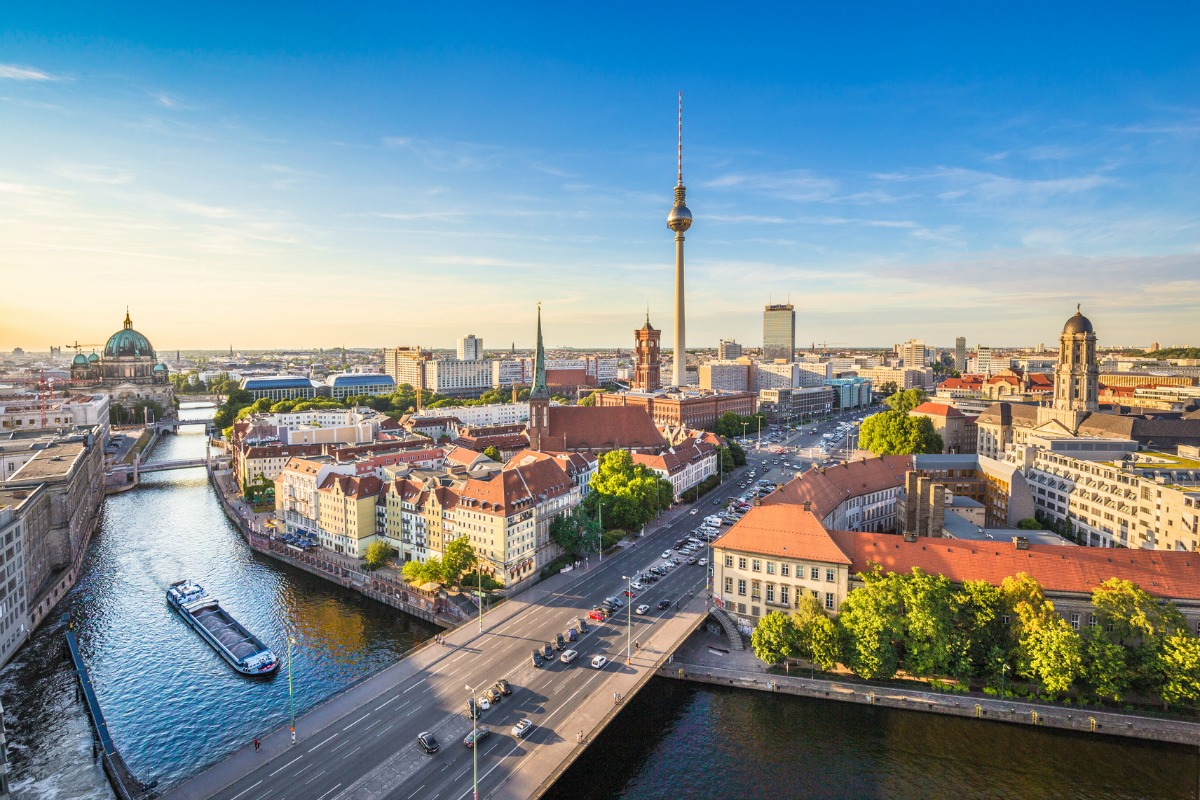

## Export the filtered company and location data to MongoDB

In [47]:
db = client['Ironhack']

# insert the filtered company database into the target_comps in MongoDB
collection = db['target_comps']
df_target_comps.reset_index(inplace=True)
data_dict = df_target_comps.to_dict("records")
# Insert collection
collection.insert_many(data_dict)

In [48]:
# insert the London attractions into MongoDB
collection = db['London']
df_london.reset_index(inplace=True)
data_dict = df_london.to_dict("records")
# Insert collection
collection.insert_many(data_dict)

In [49]:
# insert the Berlin attractions into MongoDB
collection = db['Berlin']
df_berlin.reset_index(inplace=True)
data_dict = df_berlin.to_dict("records")
# Insert collection
collection.insert_many(data_dict)

In [50]:
# insert the Melbourne attractions into MongoDB
collection = db['Melbourne']
df_melbourne.reset_index(inplace=True)
data_dict = df_melbourne.to_dict("records")
# Insert collection
collection.insert_many(data_dict)